# Notebook for replicating figures from Drake et al. 2019 on the Abyssal Circulation

Note: may need to `build IJulia` in the anaconda environment that jupyter lab is launched from and `build NetCDF` before `using` it.

In [1]:
add_gsw = false
build_packages = false

if build_packages
    using Pkg
    Pkg.build("IJulia")
    Pkg.build("NetCDF")
end

dir = "../pgcm/"
using Statistics
using NetCDF
using NaNMath; nm=NaNMath
using PyCall
using PyPlot
using Interpolations
using MAT

if add_gsw
    using Conda
    Conda.add("gsw")
end
gsw = pyimport("gsw");

nanmean(a) = mean(filter(!isnan,a));
nanmean(a, dims) = mapslices(nanmean, a, dims = dims);

dpi = 200;

In [2]:
N = sqrt(1.5)*1.e-3
#layer_scale = mean(exp.(-((2500:100:5000)+z0)/1000)) # average of exponential decay of abyssal layer
H = 2500.
Htop = 2500.
B = 2.e-11
L = 6e6
Uscale = (N^2)*(H^2)/(B*L^2)*1e3
Wscale = (N^2)*(H^3)/(B*L^3)*1e3
Tscale = (N^2)*(H^3)/(B*L)*1.e-6
kscale = 5.e-2;

dt = 2.e-5
dt_recip = Int(round(dt^-1))

#topo_col = (21./255.,30./255.,68./255.)
topo_col = (0.75,0.75,0.80);

PyCall.PyDict(matplotlib."rcParams")["font.size"]=15;


# Sensitivity to kbot

ridge-0.6_del-inf_kappa-0.025
ridge-0.6_del-inf_kappa-0.041
ridge-0.6_del-inf_kappa-0.066
ridge-0.6_del-inf_kappa-0.107
ridge-0.6_del-inf_kappa-0.175
ridge-0.6_del-inf_kappa-0.284
ridge-0.6_del-inf_kappa-0.461
ridge-0.6_del-inf_kappa-0.750
ridge-0.6_del-0.4_kappa-0.025
ridge-0.6_del-0.4_kappa-0.041
ridge-0.6_del-0.4_kappa-0.066
ridge-0.6_del-0.4_kappa-0.107
ridge-0.6_del-0.4_kappa-0.175
ridge-0.6_del-0.4_kappa-0.284
ridge-0.6_del-0.4_kappa-0.461
ridge-0.6_del-0.4_kappa-0.750
ridge-0.6_del-0.2
ridge-0.6_del-0.3
ridge-0.6_del-0.4
ridge-0.6_del-0.5
ridge-0.6_del-0.8
ridge-0.6_del-1.0
ridge-0.6_del-2.0
ridge-0.6_del-4.0


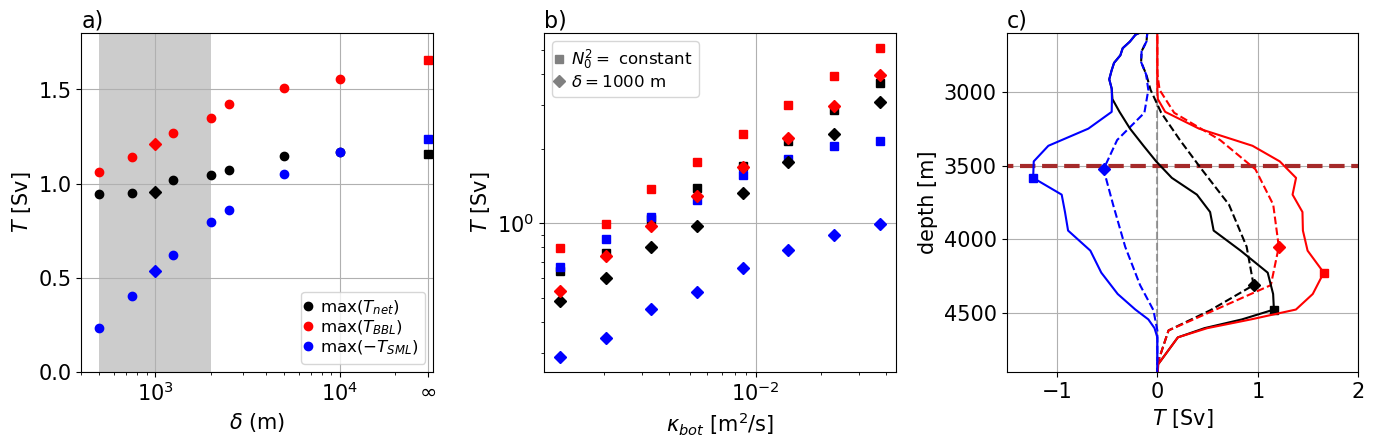

ridge-0.6_del-inf


In [3]:
dir = "../pgcm/"

strats = ["ridge-0.6_del-inf_kappa-", "ridge-0.6_del-0.4_kappa-"]
markers = ["s", "D"]

kappas = ["0.025", "0.041", "0.066", "0.107", "0.175", "0.284", "0.461", "0.750"]

expname = string(strats[1],kappas[1])
include(string(dir,expname,"/runs/equil/kernel.jl"))

nIter = dt_recip*28

nf = 50
del = 1.2

figure(figsize=(14,4.5))

subplot(1,3,2)
for strat_idx = 1:length(strats)
    for kappa_idx = 1:length(kappas)
        expname = string(strats[strat_idx],kappas[kappa_idx])
        println(expname)

        #------------------------  Load 3d Model data  ------------------------------

        m = load(string(dir,expname,"/runs/equil")) # Model setup
        s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

        ux,uy,us = velocities(m,s.bc);

        xc,yc,sc,hc = 
        [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
        [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

        hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
        hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

        us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
        uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
        ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

        # Interpolate all fields to cell centers before performing operations
        usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
        uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
        uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

        tht = -atan.(m.hxc)

        # Calculate vertical velocity from sigma coordinate velocities
        uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

        # Restoring
        Dr = -m.cc.*(s.bc .- m.bic)

        # Advective fluxes
        # get velocities
        Ux, Uy, Us = velocities(m,s.bc)
        # calculate advective fluxes
        hFx = m.hfx.*Ux.*ixcf(m,s.bc)
        hFy = m.hfy.*Uy.*iycf(m,s.bc)
        hFs = m.hc.*Us.*iscf(m,s.bc)

        # Advective flux divergence
        Du = zeros(size(s.bc))
        Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
        Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
        Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Advective flux divergences
        Dux = zeros(size(s.bc))
        Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
        Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

        Duy = zeros(size(s.bc))
        Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
        Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

        Dus = zeros(size(s.bc))
        Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
        Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

        # Buoyancy tendency 
        s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
        dbdt = (s1.bc .- s.bc)/(m.dt*5000.)

        # Diagnose exact diffusive flux divergence as residual of other explicit terms
        Dk = dbdt .- (Du .+ Dr)

        sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

        x_fy,y_fy = 
        [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
        [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
        sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

        ## Calculate integral constraint based on mean angle at given depth
        tht = -atan.(m.hxc)

        # Calculate transport predicted by 1D theory
        psi_inf = tan.(maximum(abs.(tht[1,100:150,25:75])))^-1*minimum(m.kfs)*Tscale

        ###############    Water mass transformation     ##################
        mins = -1.1
        dsf = round(abs(mins/nf), digits=5)
        sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
        scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

        bf = del*(exp.(sf/del) .-1.)
        dbf = bf[2:end]-bf[1:end-1]
        bc = del*(exp.(scb/del) .-1.)
        dbc = bc[2:end]-bc[1:end-1]

        itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
        bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

        zc = zeros(nf)
        for i in 1:nf
            idx = bf[i] .< bcf .< bf[i+1]
            zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
        end
        zc[isnan.(zc)] .= -1.
        zc[end] = 0.

        ########################################
        zref = vcat(copy(zc),[0])
        bref = vcat(copy(bc)[:,1,1],[0])
        nref = length(bref)
        intD = zeros(size(bref))

        BBLmask = Dk.>0.
        for i=1:m.nx
            for j=1:m.ny
                BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
            end
        end

        labels = [
            L"$T_{net}$",
            L"$T_{BBL}$",
            L"$-T_{SML}$"
        ]


        flux_list = [
            Dk,
            Dk,
            Dk
        ]

        mask_list = [
            trues(size(Dk)),
            BBLmask,
            .~BBLmask
        ]

        colors = [
            "k",
            "r",
            "b"
        ]
        
        sign_flip = [
            1.,
            1.,
            -1.
        ]

        for flux_idx = 1:length(flux_list)
            # Transformations in 3D model
            tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

            intD = zeros(size(bref))
            for i=1:1:nref
                intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
            end
            T = diff(intD)./diff(bref) #*Tscale
            T[isnan.(T)] .= 0
            
            mm, ii = findmax(abs.(T))
        
            if (strat_idx==1) & (kappa_idx==1); label = labels[flux_idx]; else; label = nothing; end
            loglog(parse(Float64,kappas[kappa_idx])*kscale, sign_flip[flux_idx]*T[ii]*Tscale, color=colors[flux_idx], marker=markers[strat_idx])
        end
    end
end
xlabel(L"$\kappa_{bot}$ [m$^{2}$/s]")
ylabel(L"$T$ [Sv]")
plot([],[],"s",color="grey",label=L"$N^{2}_{0}=$ constant")
plot([],[],"D",color="grey",label=L"$\delta=1000$ m")
grid(true)
legend(loc="upper left", labelspacing=0.1, handlelength=0, handletextpad=0.7, columnspacing=1.1, fontsize=12)

ridgeh=0.6
prefix = "ridge-0.6_del-"
strats = ["0.2", "0.3", "0.4", "0.5", "0.8", "1.0", "2.0", "4.0", "inf"]
strats_plot = ["0.2", "0.3", "0.4", "0.5", "0.8", "1.0", "2.0", "4.0", "12.0"]
dels = [0.4, 0.6, 0.8, 1.0, 1.6, 2.0, 4.0, 8.0, 20.0]
nf = 40

subplot(1,3,1)
fill_between([500.,2000.], [0., 0.], [1.8, 1.8], facecolor="grey", alpha=0.4)

subplot(1,3,3)
plot([0.,0.], [2600., 4900.], "--", alpha=0.75, color="grey")
plot([-4.,4.],(2. -ridgeh)*H*[1.,1.],"--",color="brown",lw=3.)
for strat_idx = 1:length(strats)
    expname = string(prefix,strats[strat_idx])
    println(expname)

    #------------------------  Load 3d Model data  ------------------------------

    m = load(string(dir,expname,"/runs/equil")) # Model setup
    s = load(string(dir,expname,"/runs/equil"),nIter); # Model state

    ux,uy,us = velocities(m,s.bc);

    xc,yc,sc,hc = 
    [m.xc[i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.yc[j] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.sc[k] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)],
    [m.hc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)];

    hxc = [m.hxc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hxc = slope in x-direction at cell center
    hyc = [m.hyc[1,j,i] for k in 1:length(m.sc), j in 1:length(m.yc), i in 1:length(m.xc)]; # hyc = slope in y-direction at cell center

    us_temp = cat(dims=1, zeros(1,size(us,2),size(us,3)), us, zeros(1,size(us,2),size(us,3)))
    uy_temp = cat(dims=2, zeros(size(uy,1),1,size(uy,3)), uy, zeros(size(uy,1),1,size(uy,3)))
    ux_temp = cat(dims=3, zeros(size(ux,1),size(ux,2),1), ux, zeros(size(ux,1),size(ux,2),1))

    # Interpolate all fields to cell centers before performing operations
    usc = (us_temp[1:end-1,:,:] .+ us_temp[2:end,:,:])/2.
    uyc = (uy_temp[:,1:end-1,:] .+ uy_temp[:,2:end,:])/2.
    uxc = (ux_temp[:,:,1:end-1] .+ ux_temp[:,:,2:end])/2.

    tht = -atan.(m.hxc)

    # Calculate vertical velocity from sigma coordinate velocities
    uzc = usc.*hc .+ sc.*hxc.*uxc .+ sc.*hyc.*uyc

    # Restoring
    Dr = -m.cc.*(s.bc .- m.bic)

    # Advective fluxes
    # get velocities
    Ux, Uy, Us = velocities(m,s.bc)
    # calculate advective fluxes
    hFx = m.hfx.*Ux.*ixcf(m,s.bc)
    hFy = m.hfy.*Uy.*iycf(m,s.bc)
    hFs = m.hc.*Us.*iscf(m,s.bc)

    # Advective flux divergence
    Du = zeros(size(s.bc))
    Du[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Du[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)
    Du[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Du[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)
    Du[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Du[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Advective flux divergences
    Dux = zeros(size(s.bc))
    Dux[:,:,1:m.nx-1] -= hFx./(m.hc[:,:,1:m.nx-1]*m.dx)
    Dux[:,:,2:m.nx] += hFx./(m.hc[:,:,2:m.nx]*m.dx)

    Duy = zeros(size(s.bc))
    Duy[:,1:m.ny-1,:] -= hFy./(m.hc[:,1:m.ny-1,:]*m.dy)
    Duy[:,2:m.ny,:] += hFy./(m.hc[:,2:m.ny,:]*m.dy)

    Dus = zeros(size(s.bc))
    Dus[1:m.ns-1,:,:] -= hFs./(m.hc*m.ds)
    Dus[2:m.ns,:,:] += hFs./(m.hc*m.ds)

    # Buoyancy tendency 
    s1 = load(string(dir,expname,"/runs/equil"),nIter+5000); # Model state
    dbdt = (s1.bc .- s.bc)/(m.dt*5000.)

    # Diagnose exact diffusive flux divergence as residual of other explicit terms
    Dk = dbdt .- (Du .+ Dr)

    sim_ridge_mask = (yc.>=0.) .& (yc.<=0.5) .& (xc.>0.25) .& (xc.<0.75);

    x_fy,y_fy = 
    [m.xc[i] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)],
    [m.yf[j] for k in 1:1, j in 1:length(m.yf), i in 1:length(m.xc)];
    sim_ridge_mask_yf = (y_fy.>=0.) .& (y_fy.<=0.5) .& (x_fy.>0.25) .& (x_fy.<0.75);

    ## Calculate integral constraint based on mean angle at given depth
    tht = -atan.(m.hxc)

    # Calculate transport predicted by 1D theory
    psi_inf = tan.(maximum(abs.(tht[1,100:150,25:75])))^-1*minimum(m.kfs)*Tscale

    ###############    Water mass transformation     ##################
    mins = -1.1
    dsf = round(abs(mins/nf), digits=5)
    sf = reshape(mins+dsf/2:dsf:0+dsf/2, (nf+1, 1, 1))
    scb = reshape(mins+dsf:dsf:0, (nf, 1, 1))

    del = dels[strat_idx]
    bf = del*(exp.(sf/del) .-1.)
    dbf = bf[2:end]-bf[1:end-1]
    bc = del*(exp.(scb/del) .-1.)
    dbc = bc[2:end]-bc[1:end-1]

    itp = extrapolate(interpolate((m.sc[:,1,1], m.yc[1,:,1], m.xc[1,1,:]), s.bc, Gridded(Linear())), NaN);
    bcf = itp(sf[:,1,1], m.yf[1,:,1], m.xc[1,1,:])

    zc = zeros(nf)
    for i in 1:nf
        idx = bf[i] .< bcf .< bf[i+1]
        zc[i] = sum(idx.*sf.*m.hfy.*sim_ridge_mask_yf)./sum(idx.*sim_ridge_mask_yf)
    end
    zc[isnan.(zc)] .= -1.
    zc[end] = 0.

    ########################################
    zref = vcat(copy(zc),[0])
    bref = vcat(copy(bc)[:,1,1],[0])
    nref = length(bref)
    intD = zeros(size(bref))

    BBLmask = Dk.>0.
    for i=1:m.nx
        for j=1:m.ny
            BBLmask[findmin(BBLmask[:,j,i])[2]:20,j,i] .= 0.
        end
    end

    labels = [
        L"$\max(T_{net})$",
        L"$\max(T_{BBL})$",
        L"$\max(-T_{SML})$"
    ]

    flux_list = [
        Dk,
        Dk,
        Dk
    ]

    mask_list = [
        trues(size(Dk)),
        BBLmask,
        .~BBLmask
    ]

    colors = [
        "k",
        "r",
        "b"
    ]
    
    sign_flip = [
        1.,
        1.,
        -1.
    ]
    
    zplot = 0.5*(zref[1:end-1]+zref[2:end]) * (-H) .+ Htop
    for flux_idx = 1:length(flux_list)
        # Transformations in 3D model
        tmp = flux_list[flux_idx].*(m.hc*m.ds)*m.dx*m.dy

        intD = zeros(size(bref))
        for i=1:1:nref
            intD[i] = sum(tmp[(s.bc.<=bref[i]) .& mask_list[flux_idx] .& sim_ridge_mask])
        end
        T = diff(intD)./diff(bref) #*Tscale
        T[isnan.(T)] .= 0
        
        subplot(1,3,1)
        mm, ii = findmax(abs.(T))
        
        if strat_idx==1; label = labels[flux_idx]; else; label = nothing; end
        
        dotmarker="o"
        if strats[strat_idx]=="0.4"; dotmarker="D"; linestyle="--";
        elseif strats[strat_idx]=="inf"; dotmarker="s"; linestyle="-";
        end
        
        semilogx(parse(Float64,strats_plot[strat_idx])*H, sign_flip[flux_idx]*T[ii]*Tscale, color=colors[flux_idx], marker=dotmarker, label=label)
        xlabel(L"$\delta$ (m)")
        ylabel(L"$T$ [Sv]")
        xticks([1.e3,1.e4,3.e4], [L"$10^{3}$", L"$10^{4}$", L"$\infty$"])
        xlim([4.e2, 3.2e4])
        
        subplot(1,3,3)
        if (strats[strat_idx]=="0.4") | (strat_idx==length(strats))
            plot(T*Tscale, zplot, color=colors[flux_idx], linestyle=linestyle)
            plot(T[ii]*Tscale, zplot[ii], color=colors[flux_idx], marker=dotmarker)
        end
        ylim([4900,2600])
        xlim([-1.5,2.0])
        grid(true)
        xlabel(L"$T$ [Sv]")
        ylabel("depth [m]")

    end
end
subplot(1,3,1)
ylim([0.,1.8])
yticks([0.,0.5,1.0,1.5])
grid(true)
legend(loc="lower right", labelspacing=0.1, handlelength=0, handletextpad=0.7, columnspacing=1.1, fontsize=12)
tight_layout()

subplot(1,3,1)
annotate(s="a)",xy=(0.,1.015),xycoords="axes fraction",fontsize=16)
subplot(1,3,2)
annotate(s="b)",xy=(0.,1.015),xycoords="axes fraction",fontsize=16)
subplot(1,3,3)
annotate(s="c)",xy=(0.,1.015),xycoords="axes fraction",fontsize=16)

savefig(string("../figures/transport_scaling.png"),dpi=dpi,bbox_inches="tight")